# User's metadata Analysis

This notebook helps to retrieve, analyse and visualize user's metadata for the top 10 most contributors by edits count. 
```
Dbachamnn
Irpen
Seryo93
TheDraperyFalls
LSHG
Toddy1
Yulia Romero
Mzajac
UP9
Aleksandr Grigoryev
```

In particular, this notebook contains :
* reusable functions for any users in Wikipedia
* plots visualization to see patterns
* analysis of the results to understand the impact of the metadata of a user and his editing behaviour.

The final goal of this notebook is to build a solid dataframe of users matadata that can be added to the big dataframe for creating a training set to build a LLM Classification.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from datetime import timedelta
from scipy.stats import variation
from tqdm import tqdm

## Load the utilities 

In [2]:
# Dataframe 
df = pd.read_csv('../../datas/final/small_db_preprocess.csv')

In [3]:
# Users list
top10_users = df["user"].value_counts().head(10).index.tolist()
users_list = df['user'].unique().tolist()
df_ip = df[df['user_type'] == 'Anonymous (IP)']
top10_ip_users = df_ip["user"].value_counts().head(10).index.tolist()

# Top 10 users metadata
df_top10_metadata = pd.read_csv('../../datas/interim/All Users Analysis/top10_user_profiles.csv')
df_all_user_metadata = pd.read_csv('../../datas/interim/All Users Analysis/total_user_profiles.csv')

# Top 10 users contributions 1. Registered Users 2. IP adress Users
df_reg_contrib = pd.read_csv('../../datas/interim/All Users Analysis/top_user_contribs.csv')
df_ip_contrib = pd.read_csv('../../datas/interim/All Users Analysis/ip_user_contribs_df.csv')

# Merge both contribs df
df_ip_contrib = df_ip_contrib.drop(['top', 'texthidden', 'new'], axis = 1) # clean quickly for fitting
df_contrib = pd.concat([df_reg_contrib, df_ip_contrib], ignore_index=True) 

In [7]:
df_all_user_metadata

,userid,name,editcount,registration,groups,emailable,gender,invalid,blockid,blockedby,blockedbyid,blockreason,blockedtimestamp,blockexpiry,blocknocreate,blockowntalk,blockedtimestampformatted,blockemail,blockpartial
0,847895.0,Agathoclea,41415.0,2006-01-27T20:41:08Z,"['sysop', '*', 'user', 'autoconfirmed', 'oatha...",NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200552.0,Icey,3213.0,2005-02-27T21:25:10Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69761.0,Irpen,32604.0,2004-06-03T04:10:48Z,"['*', 'user', 'autoconfirmed', 'oathauth-twofa...",NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,193.60.161.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,180985.0,AndriyK,3870.0,2005-01-31T12:56:50Z,"['extendedconfirmed', 'reviewer', '*', 'user',...",NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,NaN,2.28.10.183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2332,12864794.0,123uhjsakddsa89321l3,4383.0,2010-08-08T00:32:25Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,8417278.0,TonyBallioni,5527268.0,Suspected [[Wikipedia:Sock puppetry|sock puppe...,2018-06-08T14:34:36Z,infinite,NaN,NaN,"14:34, 8 June 2018",NaN,NaN
2333,NaN,65.93.43.212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2334,14852036.0,Wiki13,13481.0,2011-06-28T15:01:50Z,"['extendedconfirmed', 'rollbacker', '*', 'user...",NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reusable Functions 

In [6]:
def preprocess_usercontribs(df):
    """
    Ensures timestamp column is a proper datetime and sorts values.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    return df.sort_values(["username", "timestamp"])

def compute_edit_frequency(df):
    """
    Computes edit frequency metrics for each user:
    - total edits
    - active days
    - edits per day
    - edits per month
    - edits per active day (engagement intensity)
    
    Returns a DataFrame indexed by username.
    """
    df = preprocess_usercontribs(df)
    
    freq = (
        df.groupby("username")
          .agg(
              total_edits=("revid", "count"),
              first_edit=("timestamp", "min"),
              last_edit=("timestamp", "max")
          )
    )
    # Convert to metrics
    freq["active_days"] = (freq["last_edit"] - freq["first_edit"]).dt.days + 1
    freq["active_months"] = freq["active_days"] / 30.44  # precise month equivalence
    freq["edits_per_day"] = freq["total_edits"] / freq["active_days"]
    freq["edits_per_month"] = freq["total_edits"] / (freq["active_days"] / 30)
    freq["edits_per_active_day"] = freq["total_edits"] / freq["active_days"]
        
    return freq

def compute_burstiness_for_user(timestamps):
    """
    Computes burstiness B for a single user:
    
         B = (σ - μ) / (σ + μ)
    
    where μ = mean inter-event time, σ = std dev of inter-event time.
    
    Range:
    - B → -1 : perfectly regular
    - B = 0  : Poisson-like random
    - B → 1  : very bursty
    
    Returns None if insufficient data.
    """
    if len(timestamps) < 3: # means we have insufficient data
        return None
    
    deltas = np.diff(timestamps.astype("int64") // 1e9)  # seconds
    
    mu = deltas.mean()
    sigma = deltas.std()
    
    if (mu + sigma) == 0:
        return None
    return (sigma - mu) / (sigma + mu)

def compute_burstiness(df):
    """
    Computes burstiness for each user.
    Returns a DataFrame: username, burstiness.
    """
    df = preprocess_usercontribs(df)

    burstiness_list = []
    for user, group in df.groupby("username"):
        timestamps = group["timestamp"].values
        B = compute_burstiness_for_user(timestamps)
        burstiness_list.append({"username": user, "burstiness": B})
    
    return pd.DataFrame(burstiness_list)

def compute_temporal_patterns(df):
    """
    Extracts temporal patterns for each user:
    - most_active_hour
    - most_active_weekday
    - night_edit_ratio (edits 00:00–06:00)
    - weekend_edit_ratio
    
    Returns DataFrame: one row per user.
    """
    df = preprocess_usercontribs(df)

    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday  # 0=Monday
    df["is_weekend"] = df["weekday"] >= 5

    results = (
        df.groupby("username")
          .agg(
              most_active_hour=("hour", lambda x: x.value_counts().idxmax()),
              most_active_weekday=("weekday", lambda x: x.value_counts().idxmax()),
              weekend_edit_ratio=("is_weekend", "mean")
          )
    )
    
    return results

def compute_user_activity_profile(df):
    """
    Combines all activity-related metrics into a single profiling table:
    - edit frequency
    - burstiness
    - temporal patterns
    """
    freq = compute_edit_frequency(df)
    burst = compute_burstiness(df)
    patterns = compute_temporal_patterns(df)

    full = (
        freq
        .merge(burst, on="username", how="left")
        .merge(patterns, on="username", how="left")
    )

    return full

def compute_account_age(df_metadata, registration_col="registration", output_col="account_age_days"):
    """
    Compute the account age (in days) for each user given a metadata dataframe.

    Parameters
    ----------
    df_metadata : pd.DataFrame
        DataFrame containing user-level metadata, including their registration timestamp.
    
    registration_col : str, optional
        Name of the column containing registration timestamps (default: "registration").
    
    output_col : str, optional
        Name of the output column where account age will be stored (default: "account_age_days").

    Returns
    -------
    pd.DataFrame
        Same dataframe with an additional column representing the account age in days.
    
    Notes
    -----
    - If registration date is missing or invalid, age will be set to NaN.
    - Uses UTC timestamps (as provided by the Wikipedia API).
    """
    
    df = df_metadata.copy()

    # Convert registration date to datetime
    df[registration_col] = pd.to_datetime(df[registration_col], errors="coerce")

    # Compute age
    df[output_col] = (pd.Timestamp.utcnow() - df[registration_col]).dt.days

    return df

## Fonctions for Namespace

In [16]:
WIKIPEDIA_NAMESPACES = {
    -2: "Media",
    -1: "Special",
     0: "Article",
     1: "Talk",
     2: "User",
     3: "User Talk",
     4: "Wikipedia",
     5: "Wikipedia Talk",
     6: "File",
     7: "File Talk",
     8: "MediaWiki",
     9: "MediaWiki Talk",
    10: "Template",
    11: "Template Talk",
    12: "Help",
    13: "Help Talk",
    14: "Category",
    15: "Category Talk",
    100: "Portal",
    101: "Portal Talk",
    118: "Draft",
    119: "Draft Talk",
    126: "MOS",
    127: "MOS Talk",
    710: "TimedText",
    711: "TimedText Talk",
    828: "Module",
    829: "Module Talk",
    1728: "Event",
    1729: "Event Talk",
    108: "Book",
    109: "Book Talk",
    442: "Course",
    423: "Course Talk",
    444: "Institution",
    445: "Institution Talk",
    446: "Education Program",
    447: "Education Program Talk",
    2300: "Gadget",
    2301: "Gadget Talk",
    2302: "Gadget Definition",
    2303: "Gadget Definition Talk",
    2600: "Topic"
}


def add_namespace_label(df, ns_col="ns"):
    """
    Adds a column 'namespace' to the usercontribs dataframe
    that translates namespace IDs to human-readable names.

    Parameters
    ----------
    df : pd.DataFrame
        User contributions dataframe containing a column with namespace IDs.
    ns_col : str
        Column name storing the namespace ID (default: 'ns').

    Returns
    -------
    pd.DataFrame
        Copy of dataframe with new column 'namespace' (string).
    """

    df = df.copy()

    df["namespace"] = df[ns_col].map(WIKIPEDIA_NAMESPACES).fillna("Unknown namespace")

    return df

def classify_namespace_family(df):
    """
    Adds a 'namespace_family' column grouping content namespaces
    with their corresponding Talk namespaces.

    For example:
    - ns=0 and ns=1 → 'Article'
    - ns=2 and ns=3 → 'User'
    - ns=10 and ns=11 → 'Template'

    Works for all namespaces defined in the global mapping.
    """

    df = df.copy()

    df["namespace_label"] = df["ns"].map(WIKIPEDIA_NAMESPACES)
    df["namespace_family"] = df["namespace_label"].str.replace(" Talk", "")

    return df

def compute_namespace_distribution(df):
    """
    Returns a table showing how many edits a user made in each namespace.

    Output columns:
    - username
    - namespace_family
    - edit_count
    """

    df = classify_namespace_family(df)

    counts = (
        df.groupby(["username", "namespace_family"])
          .size()
          .reset_index(name="edit_count")
    )

    return counts

def compute_user_namespace_profile(df):
    """
    Computes how many edits each user made in each namespace,
    returning a pivoted table (users × namespaces).
    """

    counts = compute_namespace_distribution(df)

    pivot = counts.pivot_table(
        index="username",
        columns="namespace_family",
        values="edit_count",
        fill_value=0
    )

    return pivot

In [122]:
df_metadata_final = compute_account_age(df_all_user_metadata)
# ensure column name uniformity
df_metadata_final = df_metadata_final.rename(columns={"name": "user"})
df_enriched = df.merge(
    df_metadata_final,
    on="user",
    how="left"
)

## Plots 

This section contains all the plots analysis from the processing we have done using the different functions

### Account age VS Weaponisation

In [17]:
df_enriched["account_age_days"] = df_enriched["account_age_days"] // 365
df_enriched["age_bin"] = pd.qcut(df_enriched["account_age_days"], q=8)
df_enriched["weaponised_binary"] = df_enriched["weaponised"].eq("Weaponised").astype(int)

pivot = (
    df_enriched.groupby(["user_type", "age_bin"])["weaponised_binary"]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index="user_type", columns="age_bin", values="weaponised_binary")
)

sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Weaponisation Rate Heatmap\n(User Type × Account Age)")
plt.xlabel("Account Age Bins")
plt.ylabel("User Type")
plt.show()

NameError: name 'df_enriched' is not defined

In [108]:
sns.boxplot(
    data=df_enriched,
    x="weaponised",
    y="account_age_days",
    hue="user_type",
    palette="colorblind"
)

plt.title("Account Age Distribution by Weaponisation and User Type")
plt.ylabel("Account Age (days)")
plt.show()

username
Dbachmann              225138
Aleksandr Grigoryev    158746
Yulia Romero            68733
Mzajac                  65109
LSGH                    59468
Toddy1                  51582
Irpen                   31012
TheDraperyFalls         11163
Seryo93                  4711
212.137.36.230           1106
174.3.111.148             649
UP9                       391
94.178.235.125            300
124.190.40.8              121
217.118.81.18              45
217.118.81.21              33
77.252.47.155              26
172.202.173.230            14
24.183.100.38              13
61.102.45.248              10
Name: count, dtype: int64

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_72568/1699345864.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_reg.groupby("editcount_bin")["weaponised_binary"]
/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_72568/1699345864.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weapon_rate_bins, x="editcount_bin", y="weaponised_rate", palette="viridis")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


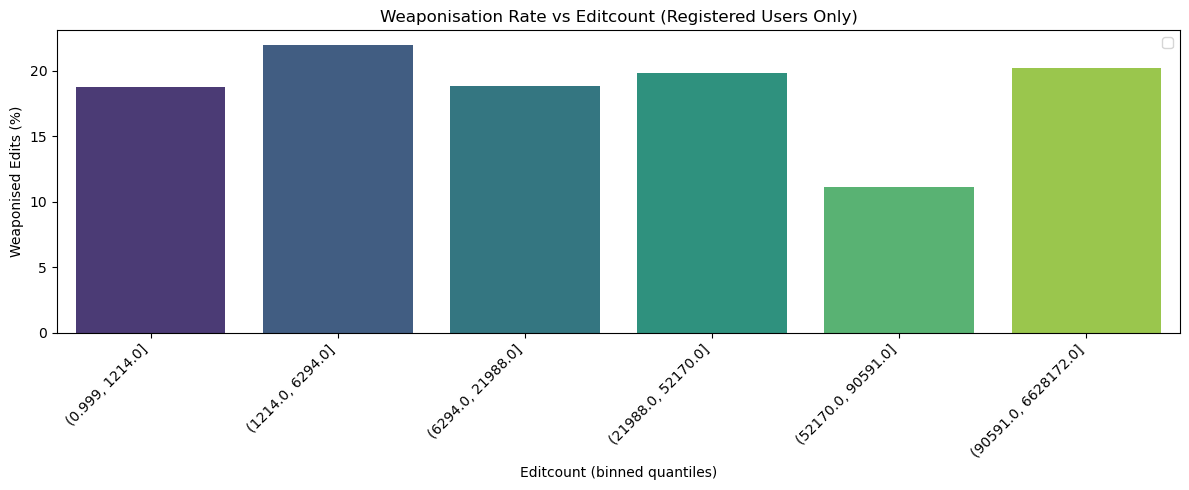

In [128]:
df_reg = df_enriched[df_enriched["user_type"] == "Registered"].copy()
df_reg["weaponised_binary"] = df_reg["weaponised"].eq("Weaponised").astype(int)
df_reg["editcount_bin"] = pd.qcut(df_reg["editcount"], q=6, duplicates="drop")

# Compute weaponisation rate per bin
weapon_rate_bins = (
    df_reg.groupby("editcount_bin")["weaponised_binary"]
          .mean()
          .mul(100)
          .reset_index(name="weaponised_rate")
)

plt.figure(figsize=(12, 5))
sns.barplot(data=weapon_rate_bins, x="editcount_bin", y="weaponised_rate", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Weaponised Edits (%)")
plt.xlabel("Editcount (binned quantiles)")
plt.title("Weaponisation Rate vs Editcount (Registered Users Only)")
plt.tight_layout()
plt.legend()
plt.show()

In [35]:
df2 = df[df['user_type'] == 'Registered']
registered_users_list = df2['user'].unique().tolist()
sublists = [registered_users_list[i:i+10] for i in range(0, len(registered_users_list), 10)]

In [28]:
import requests
from bs4 import BeautifulSoup

URL_TEMPLATE = "https://xtools.wmcloud.org/ec-rightschanges/en.wikipedia.org/{username}"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def scrape_xtools_rights_changes(username):
    url = URL_TEMPLATE.format(username=username)
    response = requests.get(url, headers=HEADERS)

    if response.status_code != 200:
        return {"user": username, "error": f"HTTP {response.status_code}"}

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the rights changes table
    table = soup.find("table", class_=lambda c: c and "rightschanges-table" in c)
    if not table:
        return {"user": username, "error": "No table found (user may have no rights changes)"}

    rows = table.find("tbody").find_all("tr")

    changes = []
    for row in rows:
        cols = [c.get_text(strip=True) for c in row.find_all("td")]
        
        if len(cols) != 4:
            continue
            
        change = {
            "timestamp": cols[0],
            "rights": cols[1],
            "performer": cols[2],
            "summary": cols[3],
        }
        changes.append(change)

    return {
        "user": username,
        "rights_changes": changes
    }

def build_dataframe_from_groups_change(username):
    data = scrape_xtools_rights_changes(username)

    # If no rights_changes key, return an empty dataframe with correct columns
    if "rights_changes" not in data:
        print('lol')
        return pd.DataFrame(columns=["timestamp", "rights", "performer", "summary", "user"])

    df_data = pd.DataFrame(data["rights_changes"])
    df_data["user"] = data["user"]
    return df_data

def run_rights_change_scraping_one_batch(sublists, batch_idx=0):
    """
    Processes exactly ONE sublist (batch) and then stops.
    batch_idx: index of the sublist to process (0-based)
    """
    df_list = []

    batch = sublists[batch_idx]
    print(f"Processing batch {batch_idx + 1}/{len(sublists)}")

    for user in batch:
        df_metadata = build_dataframe_from_groups_change(user)
        print(df_metadata.shape)
        df_list.append(df_metadata)

    if not df_list:
        return pd.DataFrame()

    df_batch = pd.concat(df_list, ignore_index=True)
    print("Batch completed. Stopping execution.")
    return df_batch


Processing batch 1/128
(2, 5)
(2, 5)
(1, 5)
(3, 5)
(2, 5)
(3, 5)
(3, 5)
(3, 5)
(1, 5)
(3, 5)
Processing batch 2/128
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
Processing batch 3/128
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
lol
(0, 5)
Processing batch 4/128
lol
(0, 5)
lol
(0, 5)


KeyboardInterrupt: 

## Templates analysis

This section is a depp analysis into the users template banner used. Templates are very often used by user as : 
* identity markers
* ideological broadcasting
* group affiliations signals
* defensive framings

In [9]:
import requests
import mwparserfromhell
import csv
import json
import time
from tqdm import tqdm

URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

SLEEP_TIME = 0.5  # be polite to the API


def fetch_wikitext(title):
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "rvslots": "main",
        "titles": title,
        "format": "json",
        "formatversion": "2"
    }

    r = requests.get(URL, params=params, headers=HEADERS)
    r.raise_for_status()
    data = r.json()

    pages = data.get("query", {}).get("pages", [])
    if not pages or "missing" in pages[0]:
        return None

    revisions = pages[0].get("revisions", [])
    if not revisions:
        return None

    return revisions[0]["slots"]["main"]["content"]


def extract_templates(wikitext):
    wikicode = mwparserfromhell.parse(wikitext)
    templates = []

    for tpl in wikicode.filter_templates(recursive=True):
        templates.append({
            "template_name": str(tpl.name).strip(),
            "parameters": {
                str(param.name).strip(): str(param.value).strip()
                for param in tpl.params
            }
        })

    return templates


def process_user(username):
    results = []

    for page_type, title in [
        ("user", f"User:{username}"),
        ("user_talk", f"User talk:{username}")
    ]:
        try:
            wikitext = fetch_wikitext(title)
            if not wikitext:
                continue

            templates = extract_templates(wikitext)

            for tpl in templates:
                results.append({
                    "username": username,
                    "page_type": page_type,
                    "template_name": tpl["template_name"],
                    "parameters": tpl["parameters"]
                })

        except Exception as e:
            print(f"[ERROR] {username} ({page_type}): {e}")

        time.sleep(SLEEP_TIME)

    return results


def run():
    all_results = []

    for user in tqdm(top10_users, desc="Processing users"):
        all_results.extend(process_user(user))

    # Save JSON (full fidelity)
    with open("user_templates_raw.json", "w", encoding="utf-8") as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)

    # Save CSV (easy inspection)
    with open("user_templates_raw.csv", "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["username", "page_type", "template_name", "parameters"]
        )
        writer.writeheader()
        for row in all_results:
            writer.writerow(row)

    print("✔ Extraction complete")

run()

Processing users: 100%|█████████████████████████| 10/10 [00:16<00:00,  1.60s/it]

✔ Extraction complete


In [10]:
df_templates = pd.read_csv('user_templates_raw.csv')

In [11]:
for ind,row in df_templates[df_templates['template_name'] == 'Babel'].iterrows():
    print(row['parameters'])

{'1': 'en-3', '2': 'ru', '3': 'uk-4'}


In [13]:
df_templates

,username,page_type,template_name,parameters
0,LSGH,user_talk,User alternative account name,{'1': 'Carbonitrous'}
1,LSGH,user_talk,clear,{}
2,LSGH,user_talk,Div col,"{'colwidth': '20em', 'style': 'column-count:3;..."
3,LSGH,user_talk,Div col end,{}
4,LSGH,user_talk,*,{}
...,...,...,...,...
410,Mzajac,user_talk,Querylink,"{'1': 'Special:Log', 'qs': 'type=delete&page=T..."
411,Mzajac,user_talk,#ifeq:alt,"{'1': 'alt', '2': '[[File:Current Events Barns..."
412,Mzajac,user_talk,Tlc,{'1': 'proposed deletion/dated'}
413,Mzajac,user_talk,Tlc,{'1': 'proposed deletion/dated'}


In [14]:
top10_users

['LSGH',
 'TheDraperyFalls',
 'Aleksandr Grigoryev',
 'Toddy1',
 'UP9',
 'Yulia Romero',
 'Irpen',
 'Seryo93',
 'Dbachmann',
 'Mzajac']